In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
data = pd.read_csv("cleaned_combined_dataset.csv")

# Convert categorical variables to numeric
data_encoded = pd.get_dummies(data, drop_first=True)

# Separate features and target variable
features = data_encoded.drop(columns=["Stress_Level_Low", "Stress_Level_High", "Stress_Level_Medium"], errors='ignore')
if "Stress_Level" in data_encoded.columns:
    target = data_encoded["Stress_Level"]
else:
    target = None  # For clustering without labels


In [3]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # You can change the strategy to 'median', 'most_frequent', or 'constant'
imputed_features = imputer.fit_transform(features)


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Quality_Of_Sleep' 'Physical_Activity_Level']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [4]:
features = features.dropna()  # This will drop rows with any NaN values


Non-numeric columns: Index(['User_Id', 'Person_Id', 'Gender', 'Age', 'Occupation', 'Stress_Level',
       'Mental_Health_Status', 'Work_Environment_Impact',
       'Support_Systems_Access', 'Online_Support_Usage'],
      dtype='object')
Features successfully normalized.


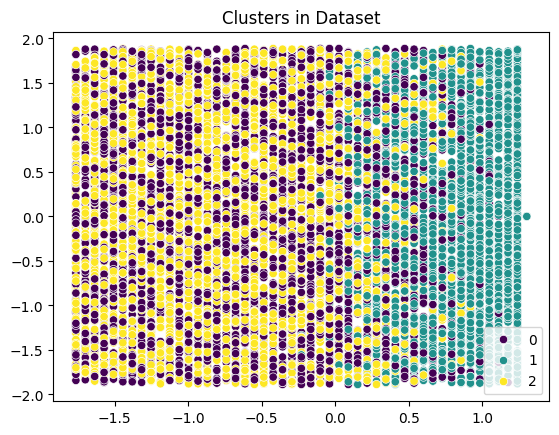

               Age  Stress_Level  Sleep_Hours  Technology_Usage_Hours  \
Cluster                                                                 
0        18.297586       3.00000     6.467729                9.537345   
1        43.361966       2.18953     6.499750                6.371633   
2        16.766866       3.00000     6.534690                3.567095   

         Social_Media_Usage_Hours  Gaming_Hours  Screen_Time_Hours  Humidity  \
Cluster                                                                        
0                        3.919103      2.573061           8.142279      20.0   
1                        4.175256      2.540467           7.807752      20.0   
2                        3.766744      2.426942           8.024510      20.0   

         Temperature  Step_Count  
Cluster                           
0               89.0  100.141429  
1               89.0  100.141429  
2               89.0  100.141429  
Model Accuracy: 1.0
              precision    recall  f1-

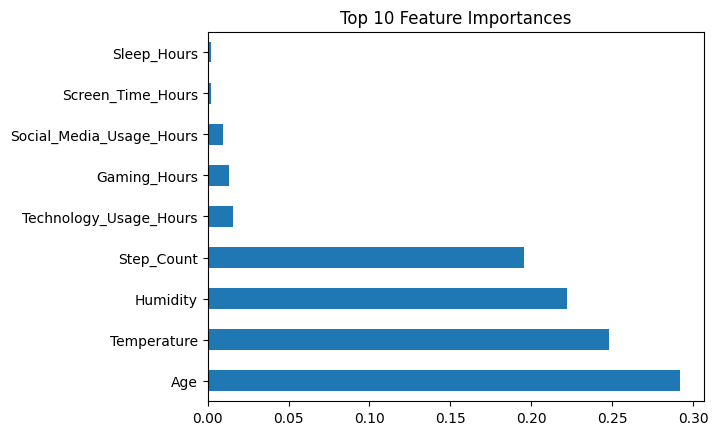

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned dataset
data = pd.read_csv("cleaned_combined_dataset.csv")

# Identify non-numeric columns
non_numeric_columns = data.select_dtypes(include=["object"]).columns
print(f"Non-numeric columns: {non_numeric_columns}")

# Convert numeric-looking strings to float
for col in non_numeric_columns:
    data[col] = pd.to_numeric(data[col], errors="coerce")

# Encode categorical columns if necessary
for col in non_numeric_columns:
    if data[col].isnull().sum() < len(data[col]):  # If some valid data exists
        data[col] = LabelEncoder().fit_transform(data[col].astype(str))

# Drop irrelevant or completely NaN columns
data = data.dropna(axis=1, how="all")  # Drop columns that are entirely NaN

# Handle missing values using imputation
imputer = SimpleImputer(strategy="mean")  # Replace NaNs with column means
data_imputed = imputer.fit_transform(data)

# Convert back to a DataFrame
data = pd.DataFrame(data_imputed, columns=data.columns)

# Separate features and target
if "Stress_Level" in data.columns:
    target = data["Stress_Level"]
    features = data.drop(columns=["Stress_Level"])
else:
    target = None  # For clustering only
    features = data

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

print("Features successfully normalized.")

# Save normalized data for inspection
features_normalized_df = pd.DataFrame(scaled_features, columns=features.columns)
features_normalized_df.to_csv("normalized_features.csv", index=False)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add cluster labels to the dataset
data["Cluster"] = clusters

# Visualize clusters
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=clusters, palette="viridis")
plt.title("Clusters in Dataset")
plt.show()

# Clustering insights
print(data.groupby("Cluster").mean())

# Train a model if target exists
if target is not None:
    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

    # Train a Random Forest classifier
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

    # Feature importance visualization
    feature_importances = pd.Series(model.feature_importances_, index=features.columns)
    feature_importances.nlargest(10).plot(kind='barh')
    plt.title("Top 10 Feature Importances")
    plt.show()


Explained variance by each principal component: [0.22648973 0.16639519 0.11769127 0.06069163 0.06006648 0.05853398
 0.05810413 0.05694066 0.03892474 0.03626303]


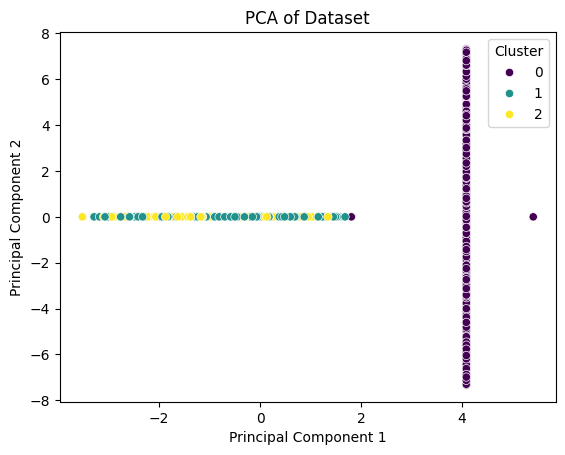

In [19]:
from sklearn.decomposition import PCA

# Applying PCA
pca = PCA(n_components=10)  # Adjust n_components based on your dataset
principal_components = pca.fit_transform(scaled_features)

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each principal component: {explained_variance}")

# Convert PCA result back to DataFrame for further analysis
pca_df = pd.DataFrame(data=principal_components, columns=[f"PC{i+1}" for i in range(principal_components.shape[1])])

# Add target and clusters if applicable
if 'Stress_Level' in data.columns:
    pca_df['Stress_Level'] = target.values
pca_df['Cluster'] = clusters

# Visualize first two principal components
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], hue=pca_df["Cluster"], palette="viridis")
plt.title("PCA of Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


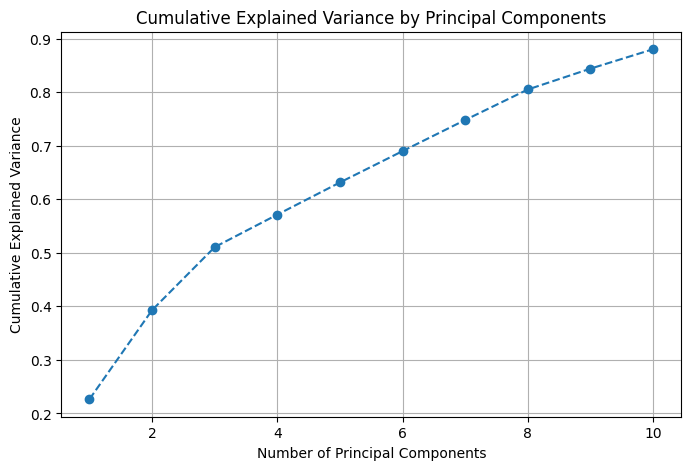

In [20]:
import numpy as np

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [21]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(principal_components, target, test_size=0.2, random_state=42)

# Create a Random Forest classifier
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Save the model to a file
joblib_file = "random_forest_model.pkl"
joblib.dump(model, joblib_file)
print(f"Model saved as {joblib_file}")


Model Accuracy: 0.43815077051228657
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89        93
         1.0       0.91      0.97      0.94       149
         2.0       1.00      1.00      1.00       159
         3.0       0.32      0.36      0.34       647
         4.0       0.35      0.34      0.34       671
         5.0       0.34      0.31      0.33       682

    accuracy                           0.44      2401
   macro avg       0.64      0.64      0.64      2401
weighted avg       0.44      0.44      0.44      2401

Model saved as random_forest_model.pkl


In [22]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate the optimized model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Model Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Save the optimized model
optimized_model_file = "optimized_random_forest_model.pkl"
joblib.dump(best_model, optimized_model_file)
print(f"Optimized model saved as {optimized_model_file}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
334 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\admin\AppData\Roaming\Python\Python311

Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best accuracy: 0.43891348906819366
Optimized Model Accuracy: 0.443981674302374
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88        93
         1.0       0.90      0.95      0.93       149
         2.0       1.00      1.00      1.00       159
         3.0       0.32      0.36      0.34       647
         4.0       0.36      0.33      0.34       671
         5.0       0.35      0.34      0.35       682

    accuracy                           0.44      2401
   macro avg       0.64      0.64      0.64      2401
weighted avg       0.44      0.44      0.44      2401

Optimized model saved as optimized_random_forest_model.pkl
